In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np

# In[25]:


def reassign(data_index_x,data_index_y,cluster_index,u,n_clusters) :
    for i in range(n_clusters) :
        if i==cluster_index :
            u[data_index_x][data_index_y][i]=1
        else :
            u[data_index_x][data_index_y][i]=0


# In[26]:


def init_membership_random(n_points_x,n_points_y,n_clusters):
    u = np.zeros((n_points_x,n_points_y, n_clusters))
    for i in range(n_points_x):
        for j in range(n_points_y):
            row_sum = 0.0
            for c in range(n_clusters):
                if c == n_clusters-1:
                    u[i][j][c] = 1.0 - row_sum
                else:
                    rand_clus = random.randint(0, n_clusters-1)
                    rand_num = random.random()
                    rand_num = round(rand_num, 2)
                    if rand_num + row_sum <= 1.0:
                        u[i][j][c] = rand_num
                        row_sum = row_sum +rand_num
    return u



# In[27]:


def distance_squared( x, c):
        sum_of_sq = 0.0
        for i in range(len(x)):
            sum_of_sq = sum_of_sq +(x[i]-c[i]) ** 2
        return sum_of_sq


# In[28]:


def compute_cluster_centers(image,u,n_clusters,m):
        n_points_x,n_points_y = image.shape

        new_image=np.zeros(u.shape)
        for c in range(n_clusters) :
            new_image[:,:,c]=image

        sum_1=np.sum(np.sum((u**m)*new_image,axis=0),axis=0)
        sum_2=np.sum(np.sum((u**m),axis=0),axis=0)

        centers = sum_1/sum_2
        return centers


# In[29]:


def update_u(data,center,u,m) :
    n_points_x,n_points_y = data.shape
    n_clusters=len(center)

    distance=np.zeros(u.shape)
    for c in range(n_clusters) :
        distance[:,:,c]=(data-center[c])**2

    for i in range(n_points_x):
        for j in range(n_points_y):
            dist = distance[i,j,:]
            update=True
            for c in range(n_clusters):
                distijc=dist[c]
                if distijc==0 :
                    reassign(i,j,c,u,n_clusters)
                    update = False
                    break
            if update==True :
                for c in range(n_clusters) :
                    sum_1=0
                    d1=dist[c]
                    for k in range(n_clusters) :
                        sum_1=sum_1+((d1/dist[k])**(1/(m-1)))
                    u[i][j][c]=(1/sum_1)


# In[30]:


def fit(X,n_clusters,max_iter,m, error):
        X = np.array(X)
        n_points_x,n_points_y = X.shape
        u=init_membership_random(n_points_x,n_points_y,n_clusters)
        centers = compute_cluster_centers(X,u,n_clusters,m)
        for i in range(max_iter):
            prev_centers=centers
            update_u(X,centers,u,m)
            centers = compute_cluster_centers(X,u,n_clusters,m)
            if abs(np.max(np.array(prev_centers)-np.array(centers)))<=error :
                return u, centers
        return u, centers

In [ ]:
import random
import numpy as np

class FuzzyCMeans:

    def __init__(self, n_clusters, max_iter, m, error, filter=None, win_size=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.filter=filter
        self.win_size = win_size

    def mean_filter(self, image,win_size) :
        n_points_x,n_points_y= image.shape

        new_image=np.zeros((n_points_x+2,n_points_y+2))
        new_image[1:n_points_x+1,1:n_points_y+1] = image
        new_dist=np.zeros(image.shape)

        for i in range(win_size) :
            for j in range(win_size) :
                if i==win_size//2 and j==win_size//2 :
                    continue
                else :
                    temp1=new_image[i:n_points_x+i , :]
                    temp1=temp1[: , j:n_points_y+j]
                    new_dist=new_dist+temp1

        return new_dist/(win_size*win_size-1)

    def median_filter(self, image,win_size) :
        n_points_x,n_points_y= image.shape

        new_image=np.zeros((n_points_x+2,n_points_y+2))
        neighb_image = np.zeros((n_points_x,n_points_y,win_size*win_size-1))
        new_image[1:n_points_x+1,1:n_points_y+1] = image
        #new_dist=np.zeros(image.shape)
        p=0
        for i in range(win_size) :
            for j in range(win_size) :
                if i==win_size//2 and j==win_size//2 :
                    continue
                else :
                    temp1=new_image[i:n_points_x+i , :]
                    temp1=temp1[: , j:n_points_y+j]
                    neighb_image[:,:,p] = temp1
                    p += 1

        return np.median(neighb_image,2)


    def reassign(self, data_index_x, data_index_y, cluster_index, u):
        for i in range(self.n_clusters):
            if i == cluster_index:
                u[data_index_x][data_index_y][i] = 1
            else:
                u[data_index_x][data_index_y][i] = 0

    def init_membership_random(self, n_points_x, n_points_y):
        u = np.zeros((n_points_x, n_points_y, self.n_clusters))
        for i in range(n_points_x):
            for j in range(n_points_y):
                row_sum = 0.0
                for c in range(self.n_clusters):
                    if c == self.n_clusters - 1:
                        u[i][j][c] = 1.0 - row_sum
                    else:
                        rand_clus = random.randint(0, self.n_clusters - 1)
                        rand_num = random.random()
                        rand_num = round(rand_num, 2)
                        if rand_num + row_sum <= 1.0:
                            u[i][j][c] = rand_num
                            row_sum += rand_num
        return u

    def compute_cluster_centers(self, image, u):
        n_points_x, n_points_y = image.shape
        new_image = np.zeros(u.shape)
        for c in range(self.n_clusters):
            new_image[:, :, c] = image
        sum_1 = np.sum(np.sum((u ** self.m) * new_image, axis=0), axis=0)
        sum_2 = np.sum(np.sum((u ** self.m), axis=0), axis=0)
        centers = sum_1 / sum_2
        return centers

    def update_u(self, data, center, u):
        n_points_x, n_points_y = data.shape
        n_clusters = len(center)
        distance = np.zeros(u.shape)
        for c in range(n_clusters):
            distance[:, :, c] = (data - center[c]) ** 2
        for i in range(n_points_x):
            for j in range(n_points_y):
                dist = distance[i, j, :]
                update = True
                for c in range(n_clusters):
                    if dist[c] == 0:
                        self.reassign(i, j, c, u)
                        update = False
                        break
                if update:
                    for c in range(n_clusters):
                        sum_1 = 0
                        d1 = dist[c]
                        for k in range(n_clusters):
                            sum_1 += (d1 / dist[k]) ** (1 / (self.m - 1))
                        u[i][j][c] = 1 / sum_1

    def fit(self, X):
        X = np.array(X)
        n_points_x, n_points_y = X.shape
        u = self.init_membership_random(n_points_x, n_points_y)
        centers = self.compute_cluster_centers(X, u)
        if self.filter=='Mean':
          X = self.mean_filter(X,self.win_size)
        if self.filter=='Median':
          X = self.median_filter(X,self.win_size)
        for i in range(self.max_iter):
            prev_centers = centers
            self.update_u(X, centers, u)
            centers = self.compute_cluster_centers(X, u)
            if np.max(np.abs(np.array(prev_centers) - np.array(centers))) <= self.error:
                return u, centers
        return u, centers

In [ ]:
import numpy as np

class FuzzyCMeansNeighbInfo:
    def __init__(self, n_clusters, max_iter, m, alpha, win_size, error):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.alpha = alpha
        self.win_size = win_size
        self.error = error

    def reassign(self, data_index_x, data_index_y, cluster_index, u):
        for i in range(self.n_clusters):
            if i == cluster_index:
                u[data_index_x][data_index_y][i] = 1
            else:
                u[data_index_x][data_index_y][i] = 0

    def find_dist(self, data, u, data_point_idx_x, data_point_idx_y, center):
        dist = []
        n_points_x, n_points_y = data.shape
        for c in range(self.n_clusters):
            sum_ = 0.0
            for i in range(data_point_idx_x - (self.win_size // 2), data_point_idx_x + 1 + (self.win_size // 2)):
                for j in range(data_point_idx_y - (self.win_size // 2), data_point_idx_y + 1 + (self.win_size // 2)):
                    if 0 <= i < n_points_x and 0 <= j < n_points_y:
                        if i == data_point_idx_x and j == data_point_idx_y:
                            continue
                        else:
                            sum_ += (data[i][j] - center[c]) ** 2
            sum_ = (sum_ * self.alpha) / (self.win_size * self.win_size - 1)
            sum_ += (data[data_point_idx_x][data_point_idx_y] - center[c]) ** 2
            if sum_ == 0:
                self.reassign(data_point_idx_x, data_point_idx_y, c, u, self.n_clusters)
                return None, False
            dist.append(sum_)
        return dist, True

    def update_u(self, data, center, u):
        n_points_x, n_points_y = data.shape
        for i in range(n_points_x):
            for j in range(n_points_y):
                dist, update = self.find_dist(data, u, i, j, center)
                if update:
                    for c in range(self.n_clusters):
                        sum_ = 0.0
                        d1 = dist[c]
                        for k in range(self.n_clusters):
                            sum_ += (d1 / dist[k]) ** (1 / (self.m - 1))
                        u[i][j][c] = 1 / sum_

    def compute_cluster_centers(self, data, u):
        n_points_x, n_points_y = data.shape
        centers = []
        for c in range(self.n_clusters):
            sum1_vec = 0.0
            sum2_vec = 0.0
            for i in range(n_points_x):
                for j in range(n_points_y):
                    sum_ = 0.0
                    for l in range(i - self.win_size // 2, i + 1 + self.win_size // 2):
                        for m in range(j - self.win_size // 2, j + 1 + self.win_size // 2):
                            if 0 <= l < n_points_x and 0 <= m < n_points_y:
                                if l == i and m == j:
                                    continue
                                else:
                                    sum_ += data[l][m]
                    sum_ = (sum_ * self.alpha) / (self.win_size * self.win_size - 1)
                    interm1 = (u[i][j][c] ** self.m)
                    interm2 = interm1 * (data[i][j] + sum_)
                    sum1_vec += interm2
                    sum2_vec += interm1
            centers.append(sum1_vec / (sum2_vec * (1 + self.alpha)))
        return centers

    def fit(self, X, init_centers):
        X = np.array(X)
        n_points_x, n_points_y = X.shape
        centers = init_centers
        u = np.zeros((n_points_x, n_points_y, self.n_clusters))
        for i in range(self.max_iter):
            prev_centers = centers
            self.update_u(X, centers, u)
            centers = self.compute_cluster_centers(X, u)
            # print(centers)
            if max(np.abs(np.array(prev_centers) - np.array(centers))) <= self.error:
                return u



In [ ]:
import sys
sys.path.append('/content/drive/My Drive/module')

In [ ]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=2c6f848dc0f46c00ec5bf67ab718c56890cb0c485615161f960db2d6b39be4fa
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
#import KERNEL_RPFCM_SNI
import nibabel as nib
from FCM_automated_result_brain_web_new import reshaping_linear , grounded_imaging ,processing  , fuzzy_to_crisp , clustering , indexing_final, append_result, tot_dice_score, tot_jaccard_score
from PIL import Image
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

(-0.5, 180.5, 216.5, -0.5)

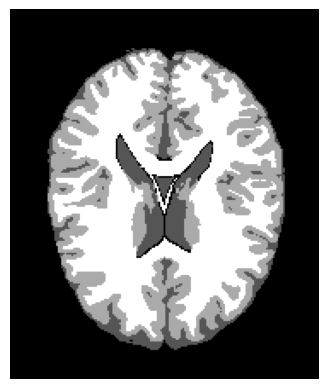

In [ ]:

img_orig = nib.load(r'/content/drive/My Drive/brain_web/phantom_1.0mm_normal_crisp.mnc')
image_gt=img_orig.dataobj[90]
image_gt[image_gt==0]=0
image_gt[image_gt==4]=0
image_gt[image_gt==5]=0
image_gt[image_gt==6]=0
image_gt[image_gt==7]=0
image_gt[image_gt==8]=0
image_gt[image_gt==9]=0
plt.imshow(image_gt, cmap='gray')
plt.axis('off')

In [ ]:
ground_set , image_act = grounded_imaging(image_gt)

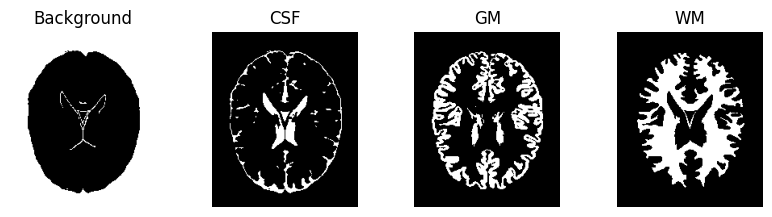

In [ ]:
plt.figure(figsize=(10,5))
columns = 4
titles = ['Background', 'CSF', 'GM', 'WM']
for i, image in enumerate(ground_set):
    plt.subplot(len(ground_set) // columns + 1, columns, i + 1)
    plt.imshow(image[1], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

(-0.5, 180.5, 216.5, -0.5)

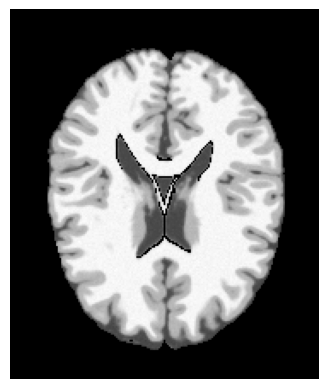

In [ ]:
img_1 = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn1_rf0.mnc')
image_1=img_1.dataobj[90]
image_1[image_gt==0]=0
plt.imshow(image_1, cmap='gray')
plt.axis('off')

Accuracy:  [0.9999750293405248, 0.9788106630211894, 0.9772162991090989, 0.9900321712989821]
Dice Score : 99.20309595946736


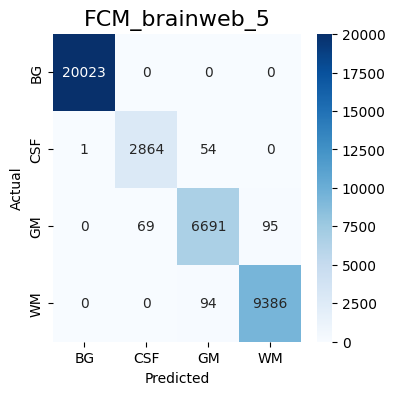

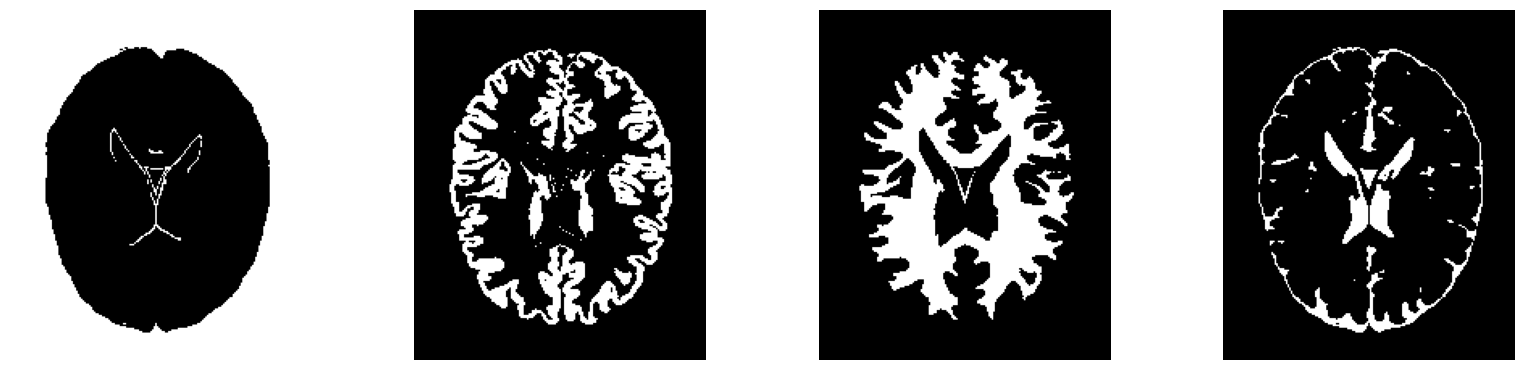

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_1)
scores = processing(u_ , 2 ,image_1 , ground_set , image_act,'FCM_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

Accuracy:  [0.9963171739947388, 0.9382303839732888, 0.9522295295222953, 0.9766106740378482]
Dice Score : 97.94027038724954


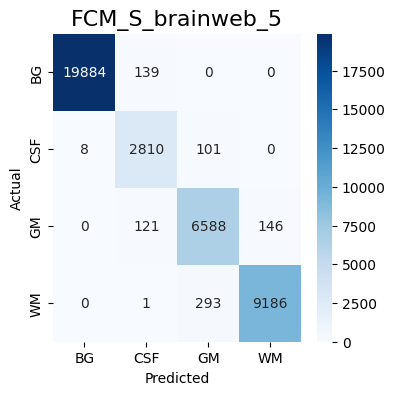

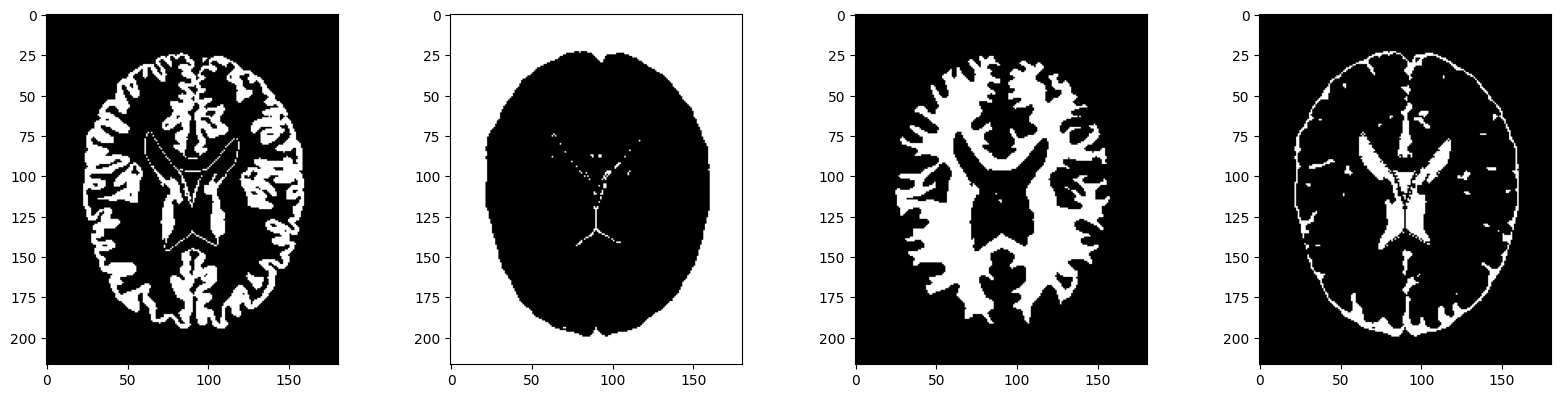

In [ ]:
init_u,init_center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_1)
u_= FuzzyCMeansNeighbInfo(4, 50, 2, 0.7, 3, 0.001).fit(image_1,init_center)
scores = processing(u_ , 2 ,image_1 , ground_set , image_act,'FCM_S_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

Accuracy:  [0.9899360020077802, 0.8521172638436482, 0.9036787830029986, 0.955969517358171]
Dice Score : 95.59793263232935


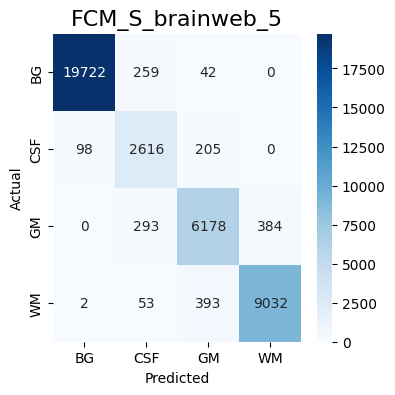

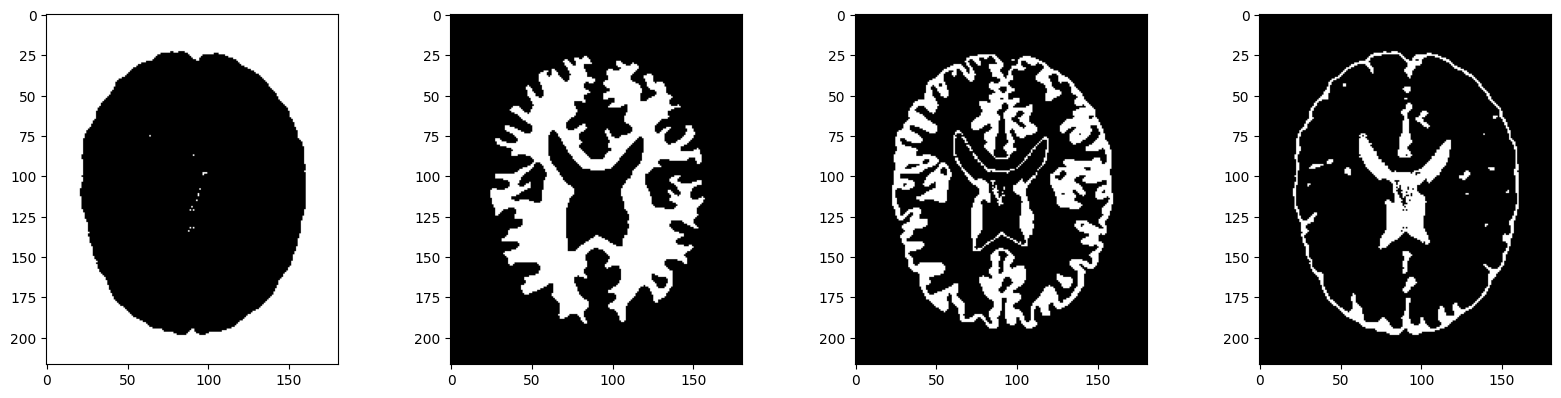

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Mean',3).fit(image_1)
scores = processing(u_ , 2 ,image_1 , ground_set , image_act,'FCM_S_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

Accuracy:  [0.9902902902902903, 0.8682809548342779, 0.9241648026553142, 0.9677453468697124]
Dice Score : 96.41520482725258


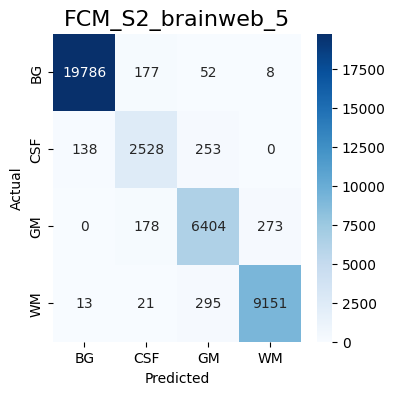

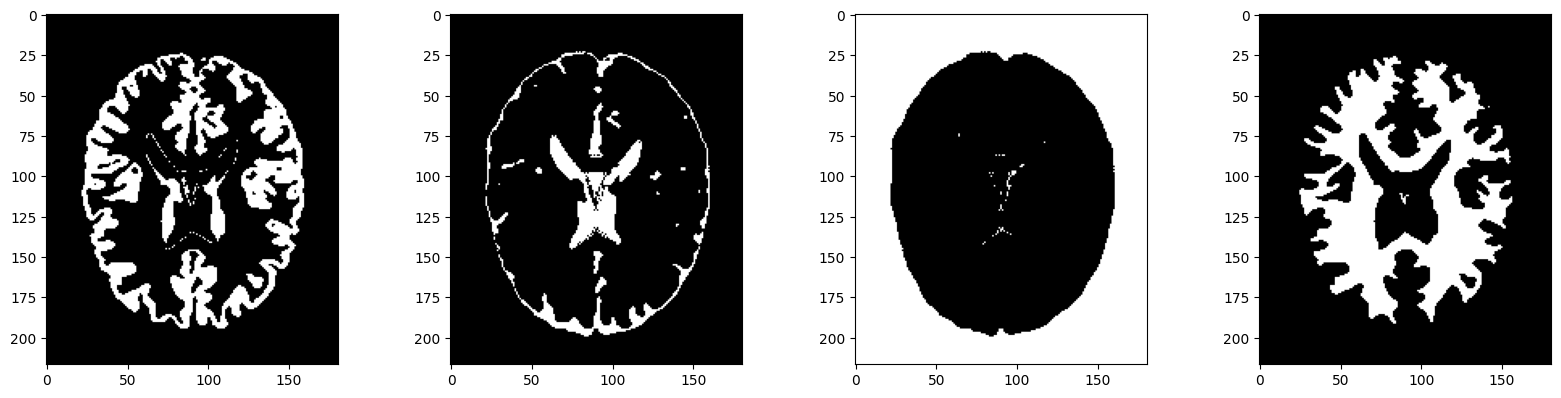

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Median',3).fit(image_1)
scores = processing(u_ , 2 ,image_1 , ground_set , image_act,'FCM_S2_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

(-0.5, 180.5, 216.5, -0.5)

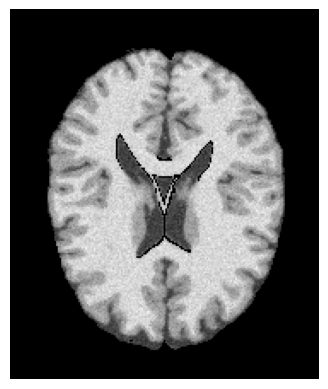

In [ ]:
img_5 = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn5_rf0.mnc')
image_5=img_5.dataobj[90]
image_5[image_gt==0]=0
plt.imshow(image_5, cmap='gray')
plt.axis('off')

Accuracy:  [0.9993262296309235, 0.9472613193149059, 0.9265785609397944, 0.9622442522674541]
Dice Score : 97.3852381801054


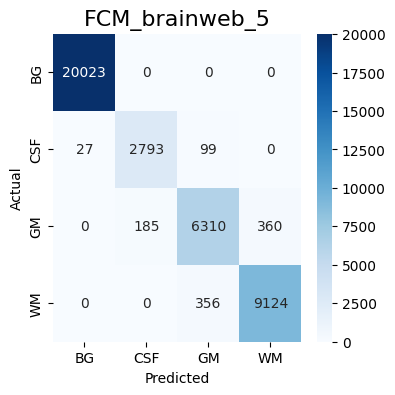

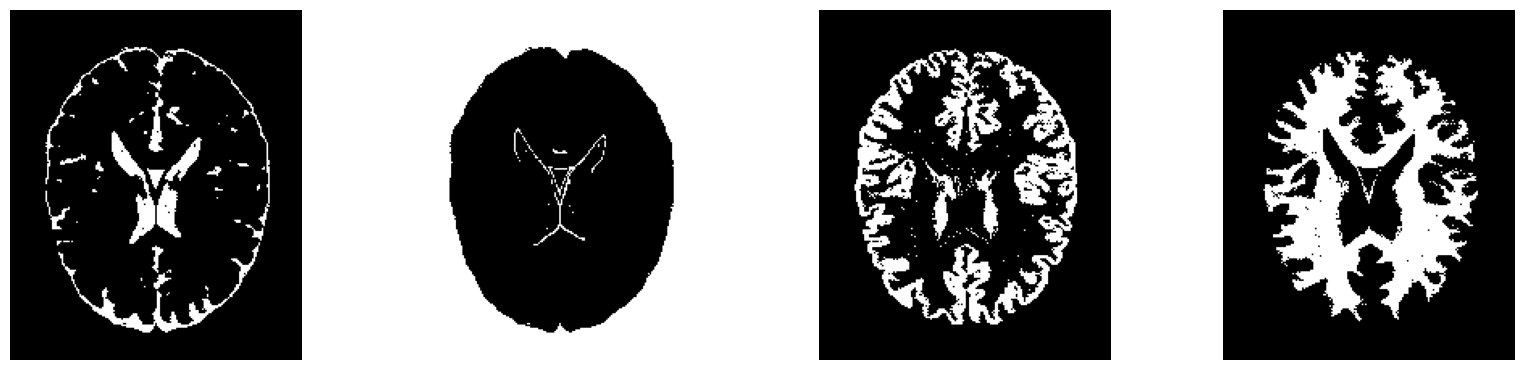

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_5)
scores = processing(u_ , 2 ,image_5 , ground_set , image_act,'FCM_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

Accuracy:  [0.9961939102564102, 0.9266024576552641, 0.93019870441808, 0.9645224585034735]
Dice Score : 97.171372559004


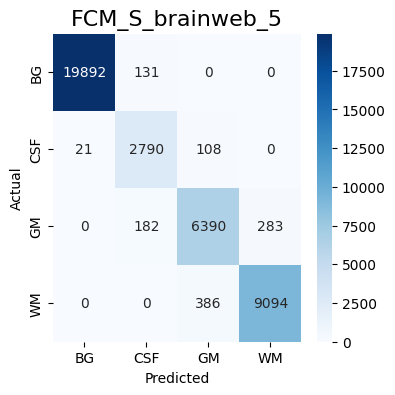

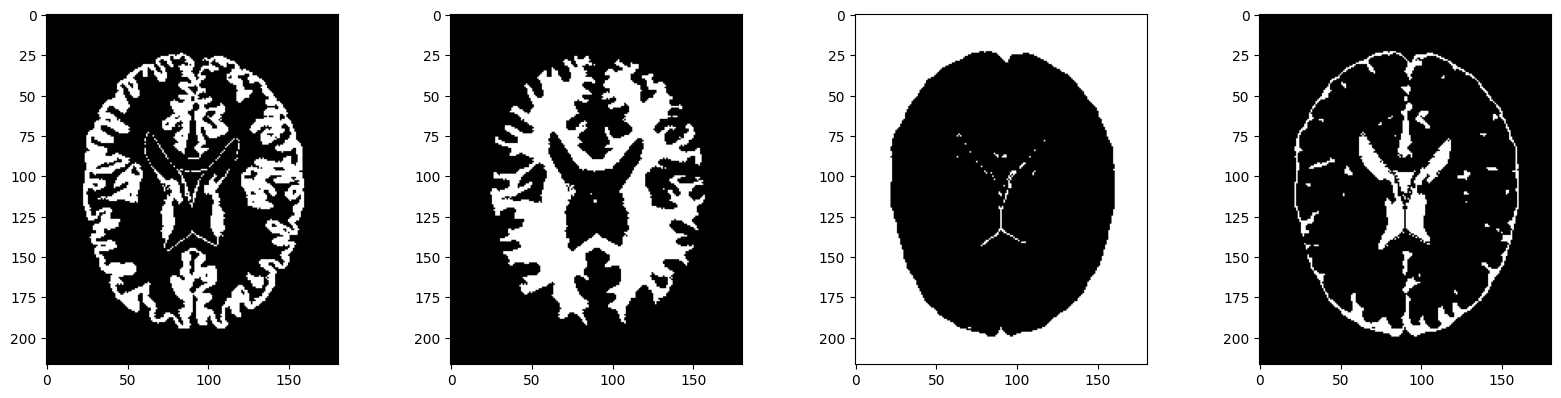

In [ ]:
init_u,init_center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_5)
u_= FuzzyCMeansNeighbInfo(4, 50, 2, 0.7, 3, 0.001).fit(image_5,init_center)
scores = processing(u_ , 2 ,image_5 , ground_set , image_act,'FCM_S_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

Accuracy:  [0.9899365071398097, 0.8520516593101194, 0.8989521506558218, 0.9528585757271816]
Dice Score : 95.44517147439979


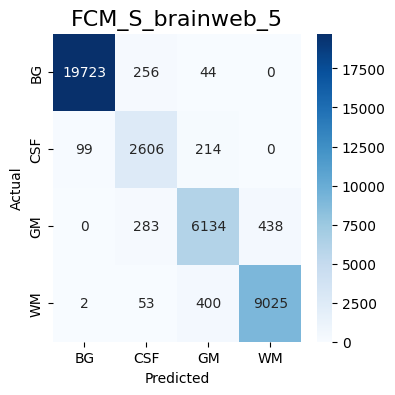

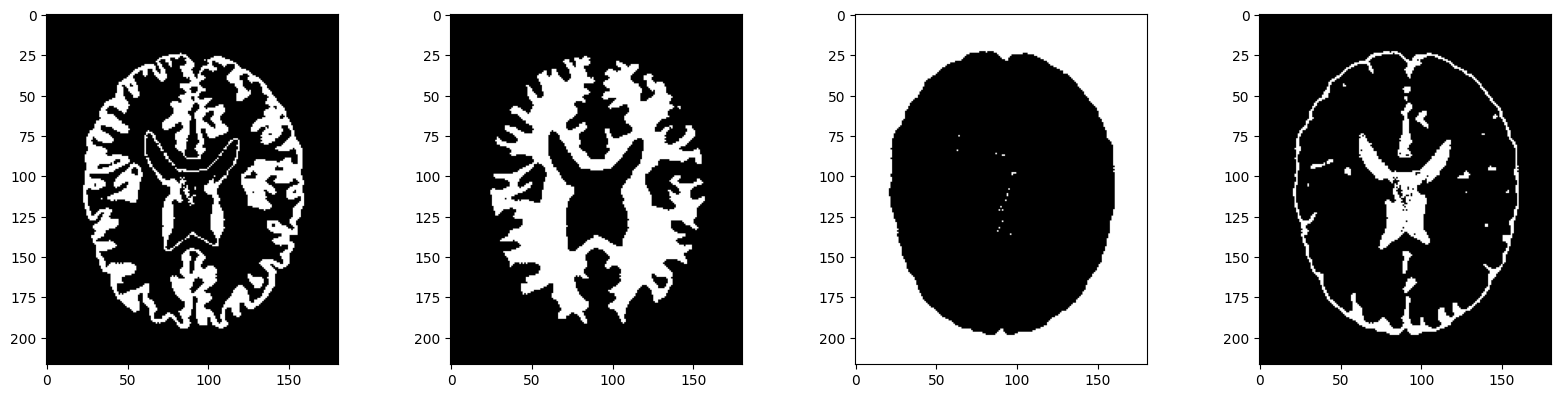

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Mean',3).fit(image_5)
scores = processing(u_ , 2 ,image_5 , ground_set , image_act,'FCM_S_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

Accuracy:  [0.9903184649638506, 0.869669054930058, 0.9143398702340162, 0.9615829912640774]
Dice Score : 96.10968251139343


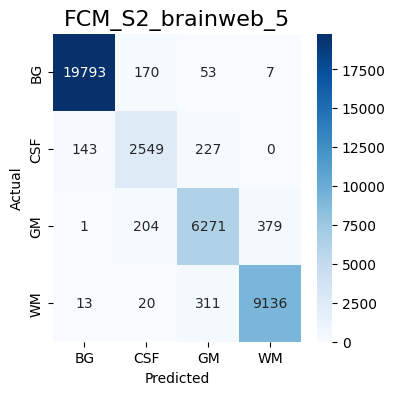

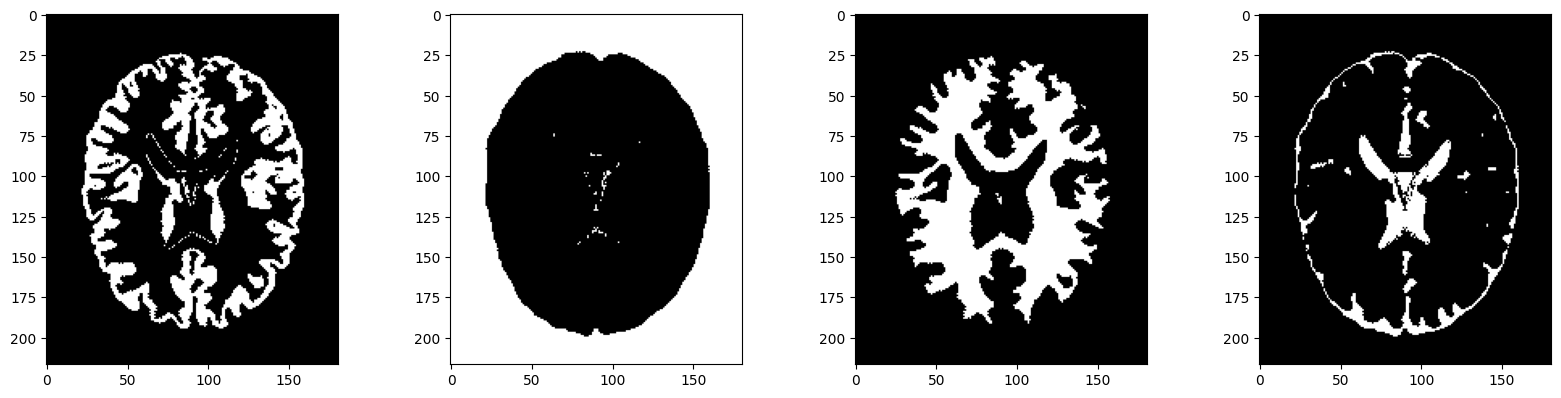

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Median',3).fit(image_5)
scores = processing(u_ , 2 ,image_5 , ground_set , image_act,'FCM_S2_brainweb_5')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

(-0.5, 180.5, 216.5, -0.5)

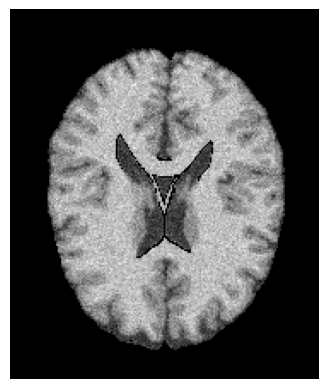

In [ ]:
img_9 = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn9_rf0.mnc')
image_9=img_9.dataobj[90]
image_9[image_gt==0]=0
plt.imshow(image_9, cmap='gray')
plt.axis('off')

Accuracy:  [0.9957975879646898, 0.8576110109782075, 0.8016165626772547, 0.8842929627178469]
Dice Score : 92.44596074038242


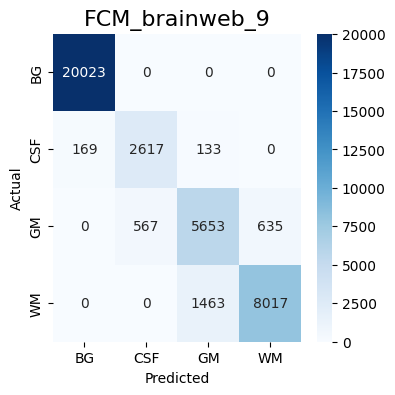

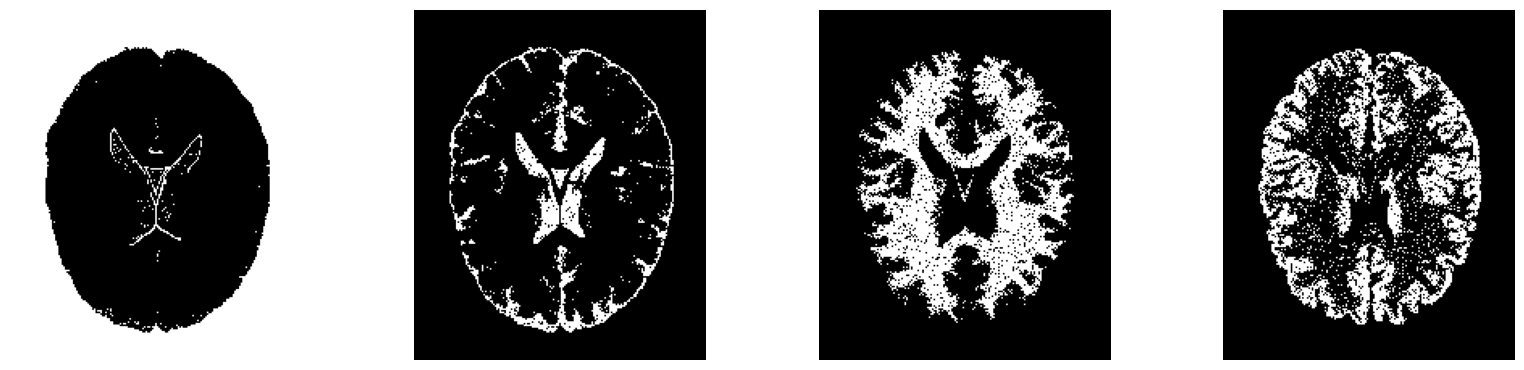

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_9)
scores = processing(u_ , 2 ,image_9 , ground_set , image_act,'FCM_brainweb_9')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

(-0.5, 180.5, 216.5, -0.5)

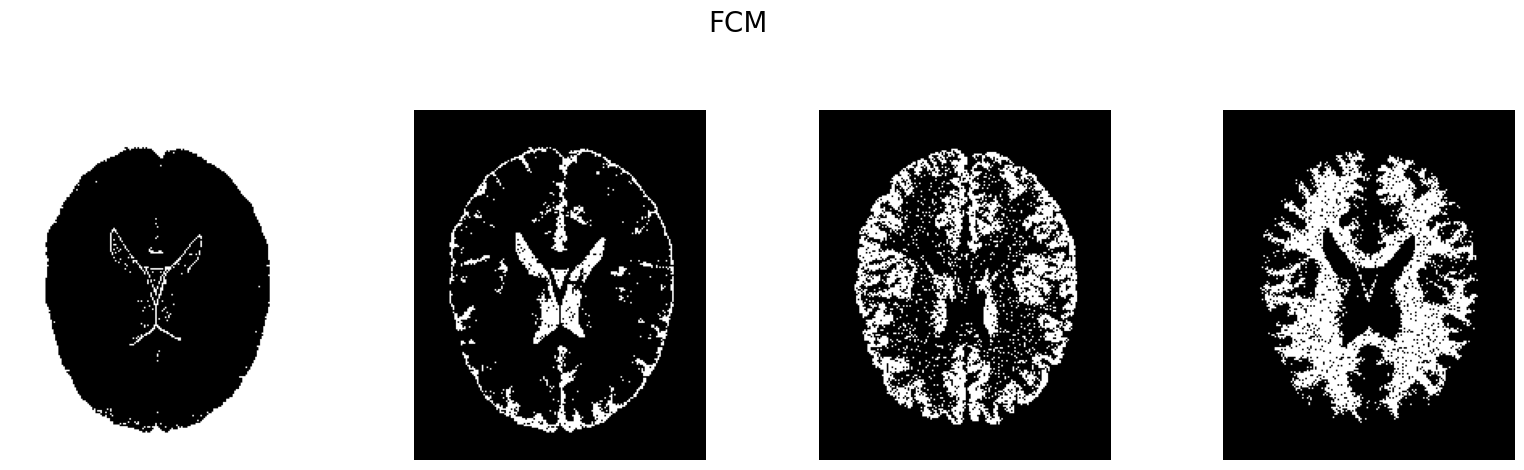

In [ ]:

plt.figure(figsize=(20,10))
plt.suptitle('FCM', fontsize=20)

columns = 4
plt.subplot(len(clustered_set) // columns + 1, columns, 0 + 1)
plt.imshow(clustered_set[0],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 1 + 1)
plt.imshow(clustered_set[1],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 2 + 1)
plt.imshow(clustered_set[3],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 3 + 1)
plt.imshow(clustered_set[2],cmap='gray')
plt.axis('off')


Accuracy:  [0.9956738102978319, 0.901747444774151, 0.8895853071933533, 0.9416338268186175]
Dice Score : 95.69722738498358


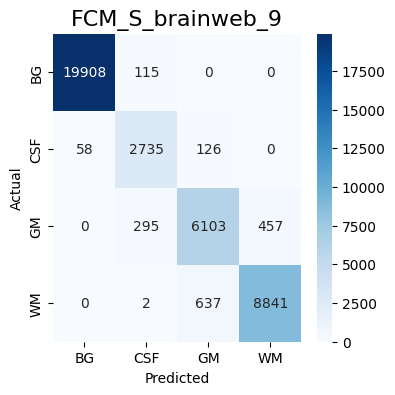

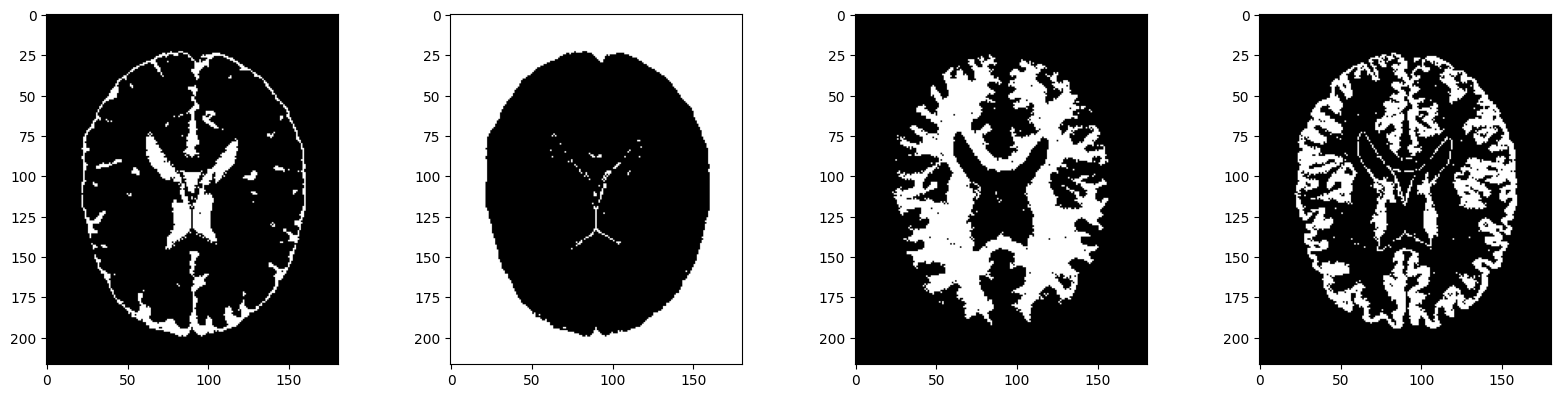

In [ ]:
# img = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn9_rf40.mnc')
# image=img.dataobj[90]
# image[image_gt==0]=0
# plt.imshow(image, cmap='gray')
# imag = image
init_u,init_center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_9)
u_= FuzzyCMeansNeighbInfo(4, 50, 2, 0.7, 3, 0.001).fit(image_9,init_center)
scores = processing(u_ , 2 ,image_9 , ground_set , image_act,'FCM_S_brainweb_9')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

(-0.5, 180.5, 216.5, -0.5)

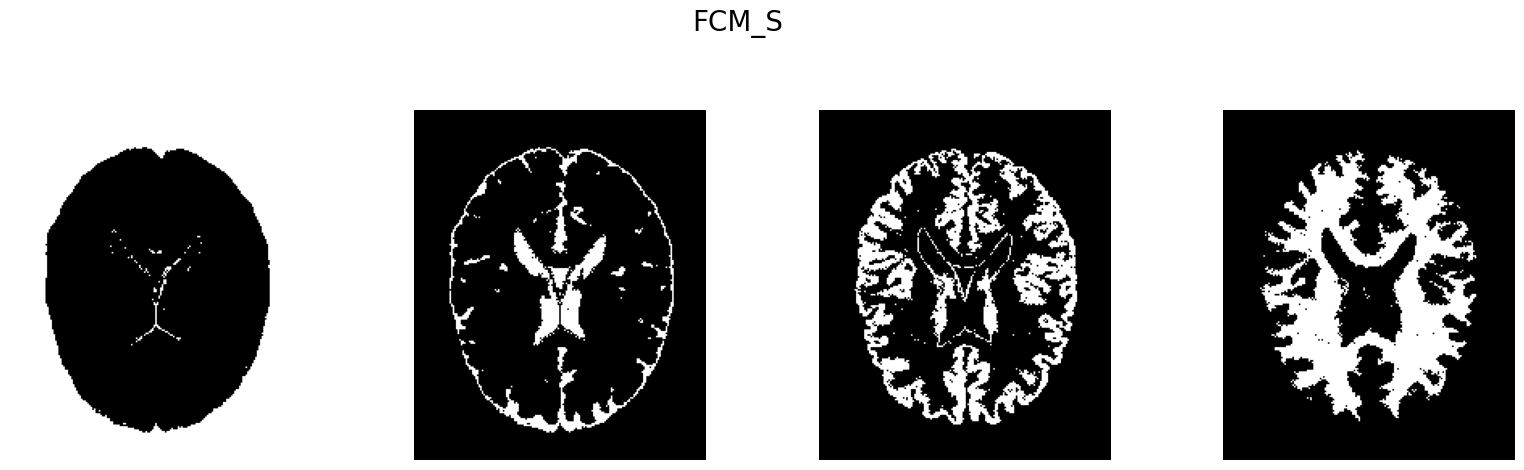

In [ ]:

plt.figure(figsize=(20,10))
plt.suptitle('FCM_S', fontsize=20)

columns = 4
plt.subplot(len(clustered_set) // columns + 1, columns, 0 + 1)
plt.imshow(clustered_set[1],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 1 + 1)
plt.imshow(clustered_set[0],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 2 + 1)
plt.imshow(clustered_set[3],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 3 + 1)
plt.imshow(clustered_set[2],cmap='gray')
plt.axis('off')


Accuracy:  [0.9893907852825362, 0.8359477124183007, 0.8777622788341531, 0.9412944778798438]
Dice Score : 94.64826743386715


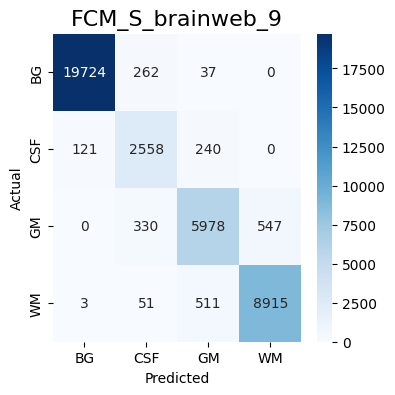

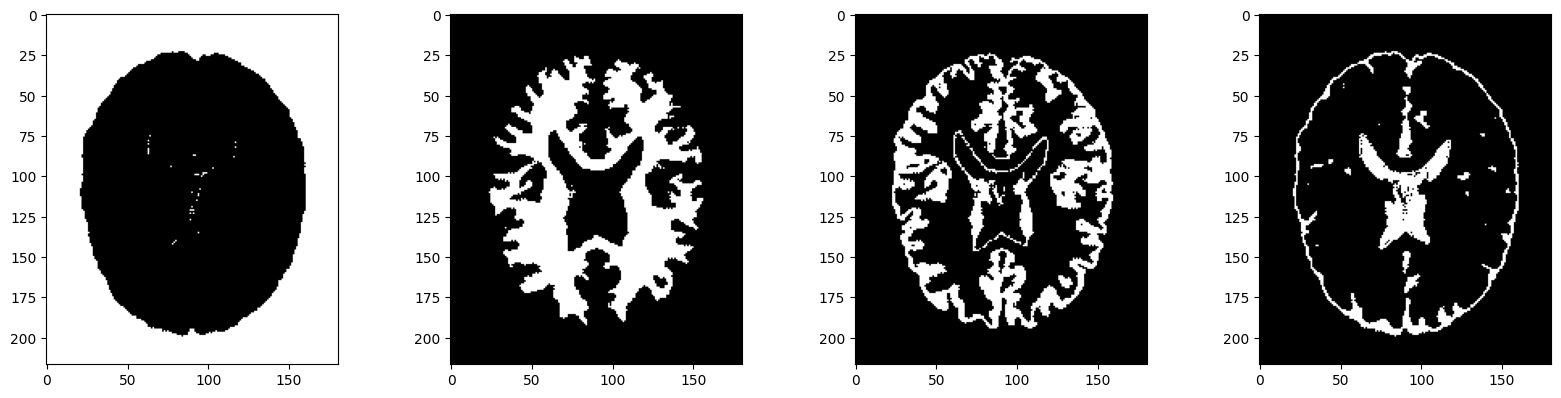

In [ ]:
# img = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn9_rf0.mnc')
# image=img.dataobj[90]
# image[image_gt==0]=0
# plt.imshow(image, cmap='gray')
# imag = image
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Mean',3).fit(image_9)
scores = processing(u_ , 2 ,image_9 , ground_set , image_act,'FCM_S_brainweb_9')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

(-0.5, 180.5, 216.5, -0.5)

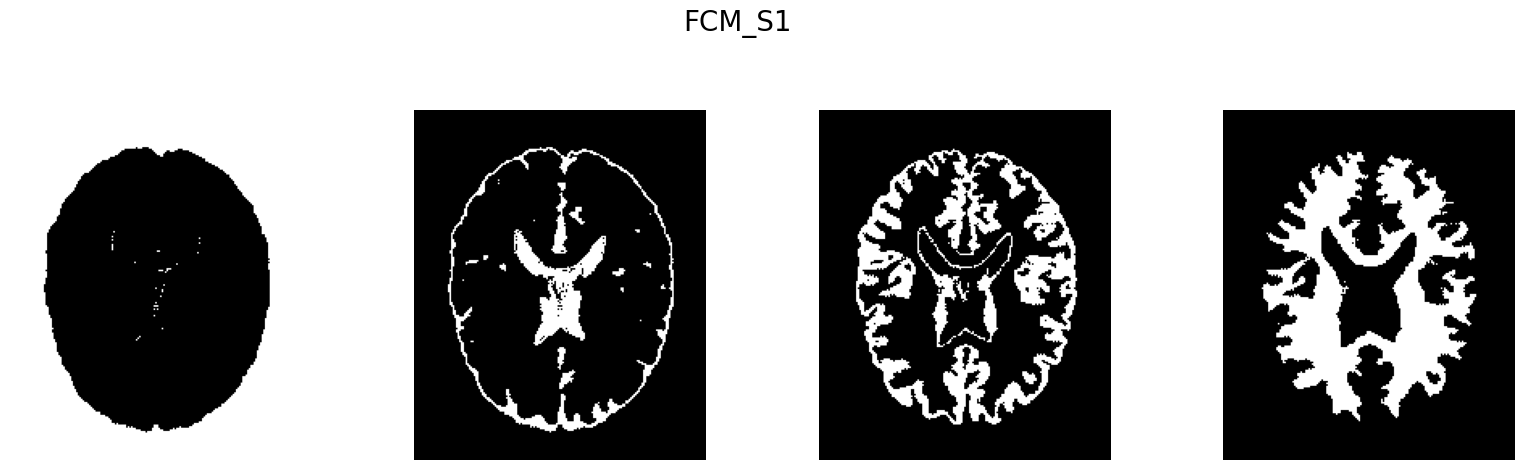

In [ ]:

plt.figure(figsize=(20,10))
plt.suptitle('FCM_S1', fontsize=20)

columns = 4
plt.subplot(len(clustered_set) // columns + 1, columns, 0 + 1)
plt.imshow(clustered_set[0],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 1 + 1)
plt.imshow(clustered_set[3],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 2 + 1)
plt.imshow(clustered_set[2],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 3 + 1)
plt.imshow(clustered_set[1],cmap='gray')
plt.axis('off')


Accuracy:  [0.9899782570664534, 0.8497970230040596, 0.884807522774023, 0.9467318714834095]
Dice Score : 95.07345265677114


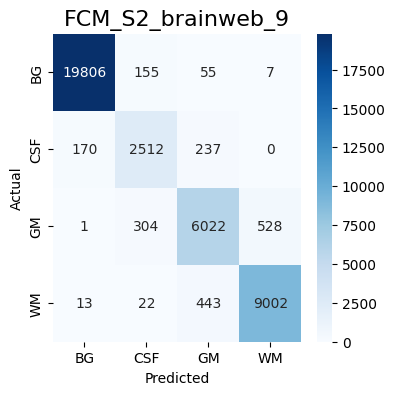

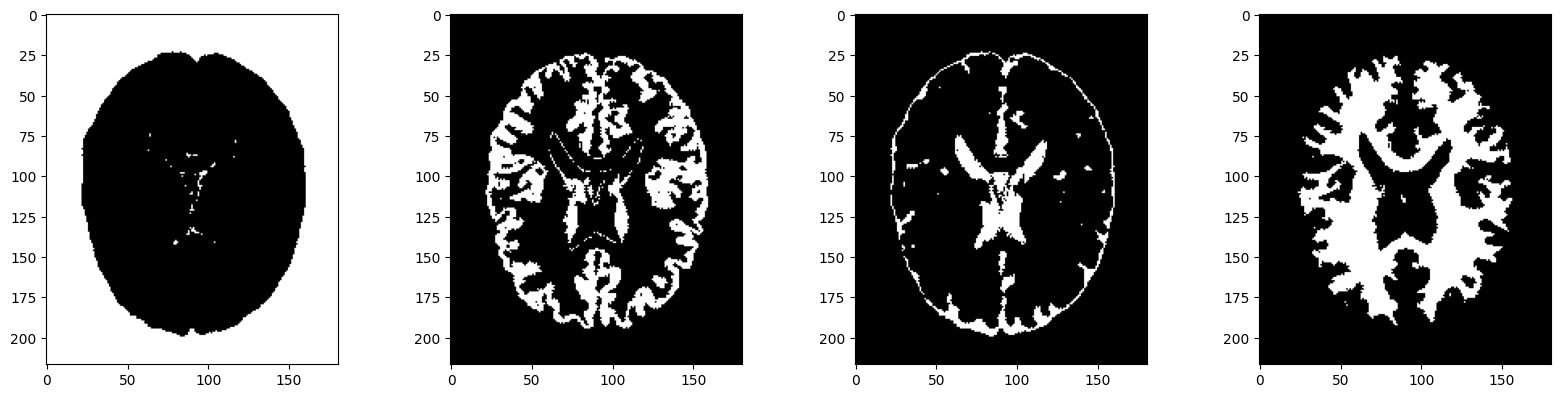

In [ ]:
u_,center= FuzzyCMeans(4, 50, 2, 0.001,'Median',3).fit(image_9)
scores = processing(u_ , 2 ,image_9 , ground_set , image_act,'FCM_S2_brainweb_9')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

(-0.5, 180.5, 216.5, -0.5)

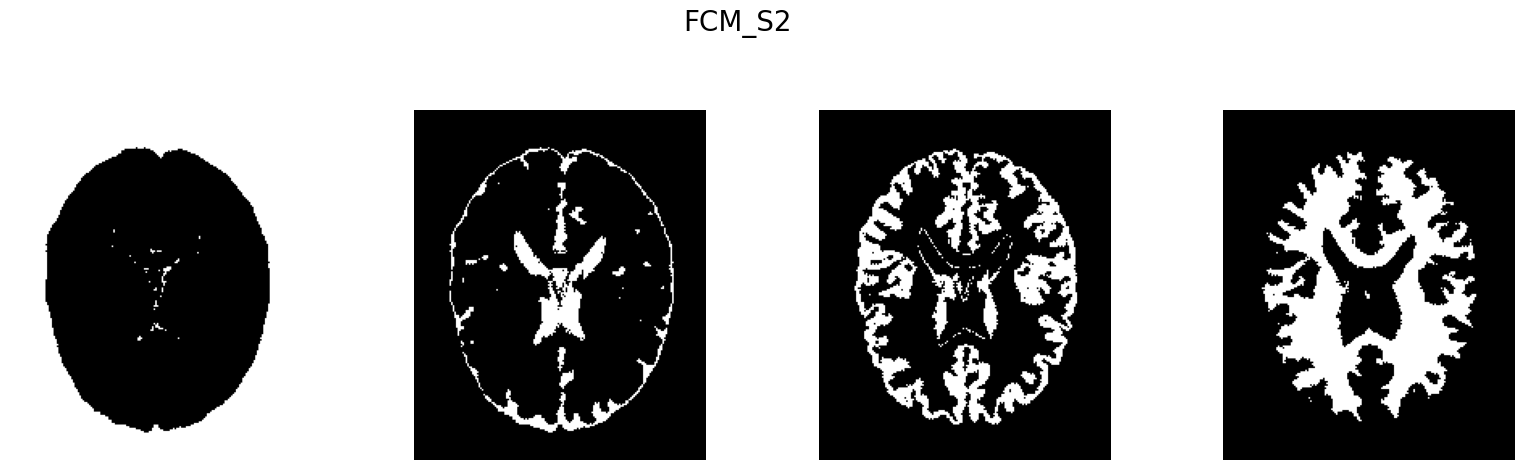

In [ ]:

plt.figure(figsize=(20,10))
plt.suptitle('FCM_S2', fontsize=20)

columns = 4
plt.subplot(len(clustered_set) // columns + 1, columns, 0 + 1)
plt.imshow(clustered_set[0],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 1 + 1)
plt.imshow(clustered_set[2],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 2 + 1)
plt.imshow(clustered_set[1],cmap='gray')
plt.axis('off')
plt.subplot(len(clustered_set) // columns + 1, columns, 3 + 1)
plt.imshow(clustered_set[3],cmap='gray')
plt.axis('off')


Accuracy:  [0.993267840223408, 0.885840108401084, 0.8970798740337819, 0.9492784837389618]
Dice Score : 95.76851592535071


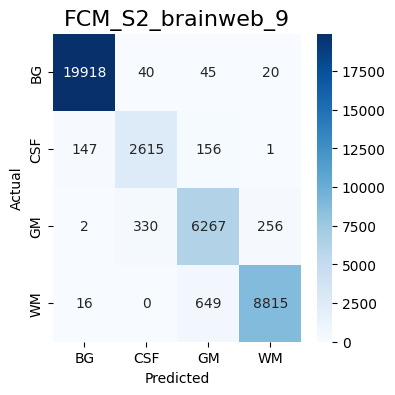

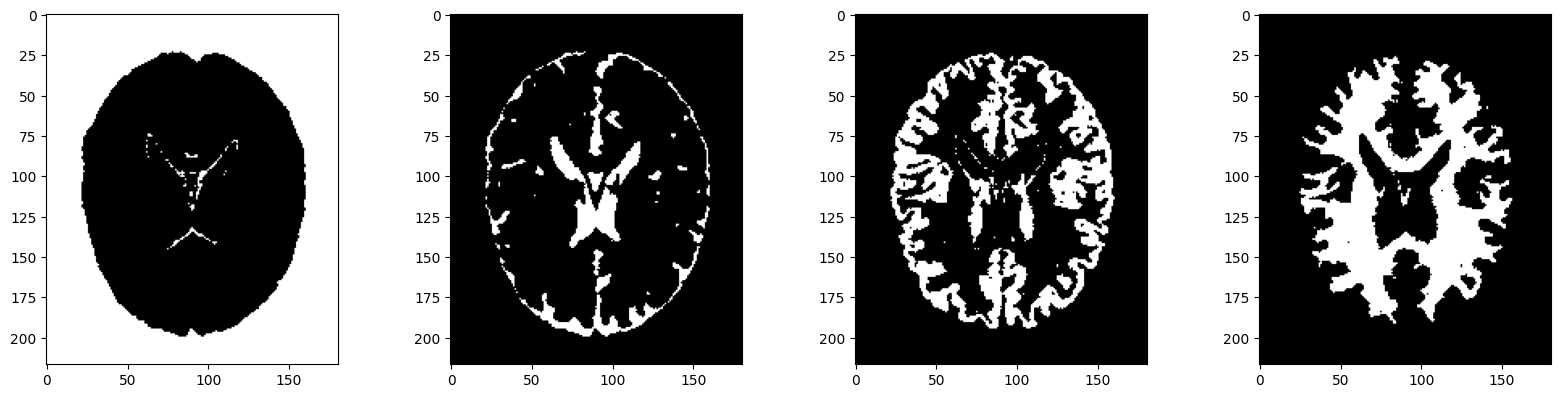

In [ ]:
from scipy import ndimage, misc

kernel = np.ones((3,3),np.uint8)
# image = cv2.morphologyEx(np.array(image_9), cv2.MORPH_CLOSE, kernel)
u_,center= FuzzyCMeans(4, 50, 2, 0.001).fit(image_9)
for c in range(4):
  u_[:,:,c] = ndimage.median_filter(u_[:,:,c], size=3)
scores = processing(u_ , 2 ,image_9 , ground_set , image_act,'FCM_S2_brainweb_9')
print('Accuracy: ',scores[0])
print('Dice Score :', scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

97.08989994144156


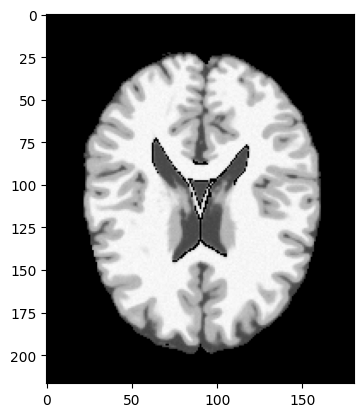

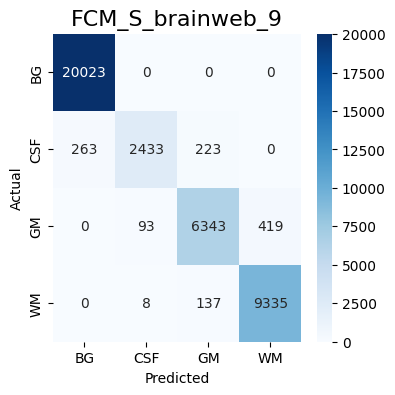

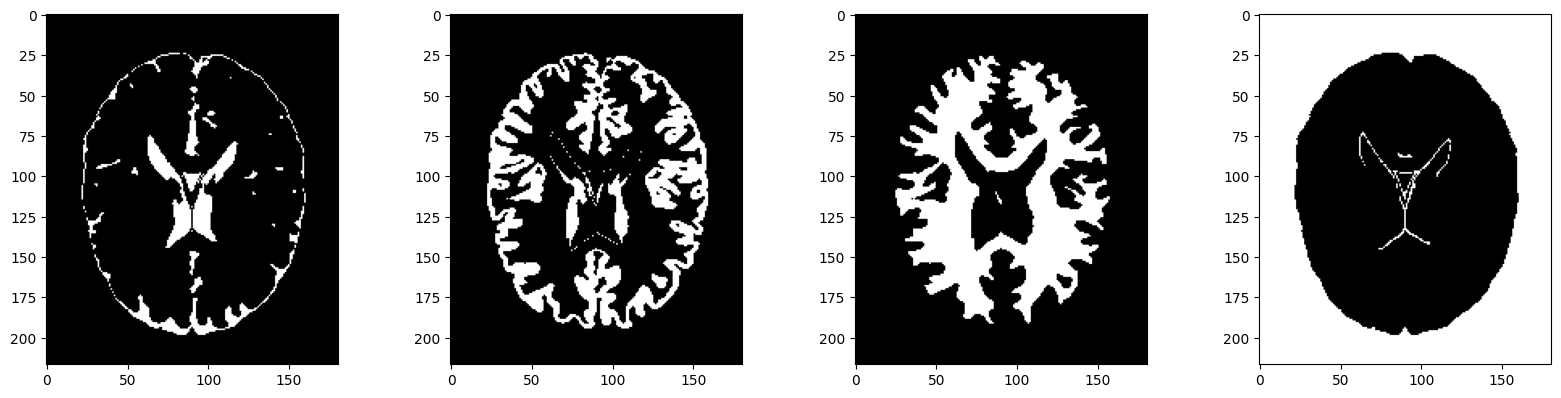

In [ ]:
img = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn1_rf0.mnc')
image=img.dataobj[90]
image[image_gt==0]=0
plt.imshow(image, cmap='gray')
imag = image
t,init_centers=fit(image,4,10,2,0.001)
u_ = FCM_S.fit(image,init_centers,4,20,2,0.7,3,0.001)
scores = processing(u_ , 2 ,imag , ground_set , image_act,'FCM_S_brainweb_9')
print(scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

In [ ]:
img = nib.load('/content/drive/MyDrive/brain_web/brain_web/3/t1_icbm_normal_1mm_pn1_rf0.mnc')
image=img.dataobj[90]
image[image_gt==0]=0
plt.imshow(image, cmap='gray')
imag = image
t,init_centers=fit(image,4,10,2,0.001)
u_ = FCM_S.fit(image,init_centers,4,20,2,0.7,3,0.001)
scores = processing(u_ , 2 ,imag , ground_set , image_act,'FCM_S_brainweb_9')
print(scores[2])
t=fuzzy_to_crisp(u_)
clustered_set=clustering(t)
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(clustered_set):
    plt.subplot(len(clustered_set) // columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[70]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from csv import writer


# In[71]:


def fuzzy_to_crisp(u) :
    x1 , y1 , c = u.shape
    im=np.zeros((y1))
    for i in range(x1) :
        for j in range(y1):
            l=max(u[i,j,:])
            for k in range(c) :
                if u[i,j,k]==l :
                    u[i,j,k]=1
                else :
                    u[i,j,k]=0
    return u


# In[72]:


def clustering(u) :
    x1,y1,c=u.shape
    cluster_set = []
    for i in range(c):
        temp = u[:,:,i]
        cluster_set.append(temp)
    return cluster_set


# In[73]:


def indexing_new(set_1 , set_2 , A) :
    cluster_set=[]
    intensity_set = []

    for set_j in set_1 :
        intense = np.sum(np.multiply(set_j,A))/np.sum(set_j)
        cluster_set.append(set_j)
        intensity_set.append(intense)

    new_cluster_set=sorting(intensity_set , cluster_set)
    proper_set = []
    for i in range(len(new_cluster_set)) :
        proper_set.append([set_2[i][1] , new_cluster_set[i]])
    return proper_set


# In[74]:


def indexing_final(clustered_set , set_2 , A ):
    avg_intensity = list()
    sorted_avg_intensity = list()
    sorted_clustered_set = list()

    for set_j in clustered_set:
        value = np.sum( np.multiply( set_j , A ) )/np.sum(set_j)
        avg_intensity.append(value)

    #for j, set_j in enumerate(clustered_set):
        #clustered_images[j] = set_j

    sorted_avg_intensity =sorted(avg_intensity)

    for i in range(len(sorted_avg_intensity)):
        for set_j in clustered_set:
            if (np.sum(np.multiply(set_j,A))/np.sum(set_j)) == sorted_avg_intensity[i]:
                sorted_clustered_set.append( ( set_2[i][1] , set_j ) )
    return sorted_clustered_set


# In[75]:


def sorting(set_1 , set_2) :
    intense_unsort_set = set_1
    set_1.sort()
    intense_sort_set = set_1
    cluster_set=[]
    for i in range(len(set_1)) :
            j = intense_unsort_set.index(intense_sort_set[i])
            cluster_set.append(set_2[j])
    return cluster_set


# In[76]:


def intersect(A,B) :
    x1, y1 = A.shape
    C=np.zeros((x1,y1))
    for i in range(x1) :
        for j in range(y1) :
            if A[i][j]==1 and B[i][j]==1 :
                    C[i][j]=1
    return C


# In[77]:


def dice_score(clustered,ground) :
    intersection=intersect(clustered,ground)
    d1=2*(np.sum(intersection))
    d2=(np.sum(clustered))+(np.sum(ground))
    return d1/d2


# In[78]:


def jaccard_score(clustered,ground) :
    intersection = intersect(clustered,ground)
    d1=np.sum(intersection)
    d2=(np.sum(clustered))+(np.sum(ground))-(np.sum(intersection))
    return d1/d2

def FPR_score(clustered,ground) :
    intersection = intersect(clustered,ground)
    return (np.sum(clustered) - np.sum(intersection))/np.sum(ground)

def FNR_score(clustered, ground) :
    intersection = intersect(clustered,ground)
    return (np.sum(ground) - np.sum(intersection))/np.sum(ground)

# In[79]:


def tot_jaccard_score(pro_set) :
    all_d=[]
    for set_i in pro_set :
        all_d.append(jaccard_score(set_i[0], set_i[1]))
    return all_d


# In[80]:


def tot_dice_score(pro_set) :
    all_d=[]
    for set_i in pro_set :
        all_d.append(dice_score(set_i[0], set_i[1]))
    return all_d

def tot_FPR_score(pro_set) :
    all_fpr = []
    for set_i in pro_set :
        all_fpr.append(FPR_score(set_i[0], set_i[1]))
    return all_fpr

def tot_FNR_score(pro_set) :
    all_fnr = []
    for set_i in pro_set :
        all_fnr.append(FNR_score(set_i[0], set_i[1]))
    return all_fnr

def PC(u,m) :
    return np.sum(u**m)/(u.shape[0]*u.shape[1])

def PE(u) :
    u_ = u
    u_[u==0] = 1
    u_ = np.log(u_)
    return np.sum(u_*u)/(u.shape[0]*u.shape[1])*(-1)
# In[81]:


def reshaping_linear(image):
    x,y=image.shape
    image2d=image.reshape(x*y,1)
    return image2d


# In[82]:


def grounded_imaging(image):
    image_act = np.zeros(image.shape)
    unique_val = np.unique(image)

    image1=np.zeros((217,181))
    image2=np.zeros((217,181))
    image3=np.zeros((217,181))
    image4=np.zeros((217,181))
    for i in range(217):
        for j in range(181):
            if image[i,j]==0:
                image1[i,j]=1
            if image[i,j]==1:
                image2[i,j]=1
            if image[i,j]==2:
                image3[i,j]=1
            if image[i,j]==3:
                image4[i,j]=1

    for i in range(217):
        for j in range(181):
            if image1[i][j] == 1:
                image_act[i][j] = 0
            if image2[i][j] == 1:
                image_act[i][j] = 1
            if image3[i][j] == 1:
                image_act[i][j] = 2
            if image4[i][j] == 1:
                image_act[i][j] = 3

    ground_set=[(0,image1),(254,image2),(514,image3),(688,image4)]
    return ground_set , image_act


# In[83]:


dice_score_list = list()
jaccard_score_list = list()
accuracy_list = list()
FPR_list = list()
FNR_list = list()
PC_list = list()
PE_list = list()
ASA_list = list()


# In[84]:



def processing(u , m, image , ground_set , image_act, image_name):

    #JACCARD AND DICE SCORE
    x,y = image.shape

    PC_ = PC(u,m)
    PE_ = PE(u)
    u = fuzzy_to_crisp(u)
    clustered_set = clustering(u)
    proper_set = indexing_final(clustered_set,ground_set,image)
    dice_score = tot_dice_score(proper_set)
    jaccard_score = tot_jaccard_score(proper_set)
    FPR = tot_FPR_score(proper_set)
    FNR = tot_FNR_score(proper_set)

    image_pred=np.zeros((217,181))
    for i in range(217) :
        for j in range(181) :
            if proper_set[0][1][i][j] == 1 :
                image_pred[i][j]=0
            if proper_set[1][1][i][j] == 1 :
                image_pred[i][j]=1
            if proper_set[2][1][i][j] == 1 :
                image_pred[i][j]=2
            if proper_set[3][1][i][j] == 1 :
                image_pred[i][j]=3

    #ASA
    TOT = np.sum(ground_set[2][1]) + np.sum(ground_set[3][1]) + np.sum(ground_set[1][1])
    COR = np.sum(proper_set[2][0]*proper_set[2][1]) + np.sum(proper_set[3][0]*proper_set[3][1]) + np.sum(proper_set[1][0]*proper_set[1][1])
    ASA = COR/TOT
    ASA_list.append(ASA)
    #ACCURACY

    sum_1 = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image_pred[i][j] == image_act[i][j]:
                sum_1 = sum_1 + 1
            else:
                continue

    accuracy = (sum_1/(image.shape[0]*image.shape[1]))*100
    accuracy_list.append(accuracy)

    image_act = image_act.reshape(x*y,1)
    image_pred = image_pred.reshape(x*y,1)

    #CONFUSION MATRIX

    conf_mat = confusion_matrix(image_act, image_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                xticklabels=['BG','CSF','GM','WM'],
                yticklabels=['BG','CSF','GM','WM'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(image_name, size=16)



    return dice_score, jaccard_score, accuracy, FPR, FNR, PC_ , PE_, ASA


# In[86]:


def append_result(file_name,avg_score,Method):
    new_row=[Method]
    for i in avg_score:
        new_row.append(i)
    with open(file_name, 'a+', newline='') as write_obj :
        csv_writer=writer(write_obj)
        csv_writer.writerow(new_row)


# In[37]:





# In[ ]:





# In[ ]:




